In [2]:
"""
Project 3: Failure Mode and Effect Analysis (FMEA) for Financial Transactions
Objective: Develop a system to perform FMEA on financial transactions and visualize the results using a graph database.

Objectives 

    Develop an FMEA-Based Financial Analysis System – Implement Failure Modes and Effects Analysis (FMEA) to identify potential risks in financial transactions.
    
    Construct a Graph-Based Transaction Model – Represent financial transactions as a graph in Neo4j, with nodes as transactions and edges as relationships.
    
    Identify and Analyze Failure Modes – Detect potential failure points in transactions and assess their impact on financial operations.
    
    Compare Transactions Against Risk Benchmarks – Establish expected transaction patterns and identify deviations that indicate potential failures.
    
    Visualize and Report Insights – Generate interactive graphs and reports to highlight failure modes and improve financial risk management.

"""

'\n\n\n'

In [1]:
!pip install neo4j pandas numpy networkx matplotlib


In [2]:
from neo4j import GraphDatabase

# Neo4j connection details
URL = "bolt://localhost:7687"  r
USERNAME = "neo4j"
PASSWORD = "password"

# Connect to Neo4j
driver = GraphDatabase.driver(URL, auth=(USERNAME, PASSWORD))

print("Connected to Neo4j successfully!")


Connected to Neo4j successfully!


In [3]:
import pandas as pd
import numpy as np

# Simulate financial transactions with anomalies
np.random.seed(42)

data = {
    "transaction_id": range(1, 21),  # Transaction IDs from 1 to 20
    "account_from": ["A1", "A2", "A3", "A1", "A2", "A3", "A1", "A2", "A3", "A1",
                     "A4", "A5", "A1", "A2", "A6", "A1", "A2", "A3", "A7", "A8"],
    "account_to": ["B1", "B2", "B3", "B1", "B2", "B3", "B1", "B2", "B3", "B1",
                   "B4", "B5", "B6", "B7", "B8", "B1", "B2", "B3", "B9", "B10"],
    "amount": [100, 200, 5000, 150, 200, 5000, 100, 0, 6000, 150,  
               -50, 7500, 200, 10000, 150, 2500, 0, 9000, 180, -100],  
    "type": ["transfer", "transfer", "credit", "transfer", "transfer", "credit",
             "transfer", "transfer", "credit", "transfer",
             "refund", "credit", "transfer", "credit", "transfer",
             "transfer", "transfer", "credit", "refund", "credit"], 
    "timestamp": pd.date_range("2024-02-01", periods=20, freq="h")  # Every hour
}

# Convert to DataFrame
df = pd.DataFrame(data)

print(df)


    transaction_id account_from account_to  amount      type  \
0                1           A1         B1     100  transfer   
1                2           A2         B2     200  transfer   
2                3           A3         B3    5000    credit   
3                4           A1         B1     150  transfer   
4                5           A2         B2     200  transfer   
5                6           A3         B3    5000    credit   
6                7           A1         B1     100  transfer   
7                8           A2         B2       0  transfer   
8                9           A3         B3    6000    credit   
9               10           A1         B1     150  transfer   
10              11           A4         B4     -50    refund   
11              12           A5         B5    7500    credit   
12              13           A1         B6     200  transfer   
13              14           A2         B7   10000    credit   
14              15           A6         

In [4]:
def insert_transaction(tx, transaction):
    query = """
    CREATE (t:Transaction {transaction_id: $transaction_id, account_from: $account_from,
                           account_to: $account_to, amount: $amount, type: $type, timestamp: $timestamp})
    """
    tx.run(query, **transaction)

# Insert each row from DataFrame into Neo4j
with driver.session() as session:
    for _, row in df.iterrows():
        session.write_transaction(insert_transaction, row.to_dict())

print("Inserted transactions into Neo4j!")


C:\Users\loksa\AppData\Local\Temp\ipykernel_11992\1887174912.py:11: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insert_transaction, row.to_dict())


Inserted transactions into Neo4j!


In [5]:
def create_relationships(tx):
    query = """
    MATCH (t1:Transaction), (t2:Transaction) 
    WHERE t1.timestamp < t2.timestamp
    CREATE (t1)-[:NEXT_TRANSACTION]->(t2)
    """
    tx.run(query)

with driver.session() as session:
    session.write_transaction(create_relationships)

print("Created transaction relationships in Neo4j!")


C:\Users\loksa\AppData\Local\Temp\ipykernel_11992\1050183942.py:10: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_relationships)


Created transaction relationships in Neo4j!


In [6]:
# Define failure modes
large_amount_threshold = 3000

df["large_amount"] = df["amount"] > large_amount_threshold
df["zero_amount"] = df["amount"] == 0

# Detect duplicate transactions
df["duplicate"] = df.duplicated(subset=["account_from", "account_to", "amount", "timestamp"], keep=False)

# Define failure modes
df["failure_mode"] = df["large_amount"] | df["zero_amount"] | df["duplicate"]

print(df[["transaction_id", "large_amount", "zero_amount", "duplicate", "failure_mode"]])


    transaction_id  large_amount  zero_amount  duplicate  failure_mode
0                1         False        False      False         False
1                2         False        False      False         False
2                3          True        False      False          True
3                4         False        False      False         False
4                5         False        False      False         False
5                6          True        False      False          True
6                7         False        False      False         False
7                8         False         True      False          True
8                9          True        False      False          True
9               10         False        False      False         False
10              11         False        False      False         False
11              12          True        False      False          True
12              13         False        False      False         False
13    

In [7]:
def mark_failures(tx, transaction_id, failure_mode):
    query = """
    MATCH (t:Transaction {transaction_id: $transaction_id})
    SET t.failure_mode = $failure_mode
    """
    tx.run(query, transaction_id=int(transaction_id), failure_mode=bool(failure_mode))

with driver.session() as session:
    for _, row in df.iterrows():
        session.write_transaction(mark_failures, row["transaction_id"], row["failure_mode"])

print("Marked failure modes in Neo4j!")


C:\Users\loksa\AppData\Local\Temp\ipykernel_11992\2726783943.py:10: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(mark_failures, row["transaction_id"], row["failure_mode"])


Marked failure modes in Neo4j!


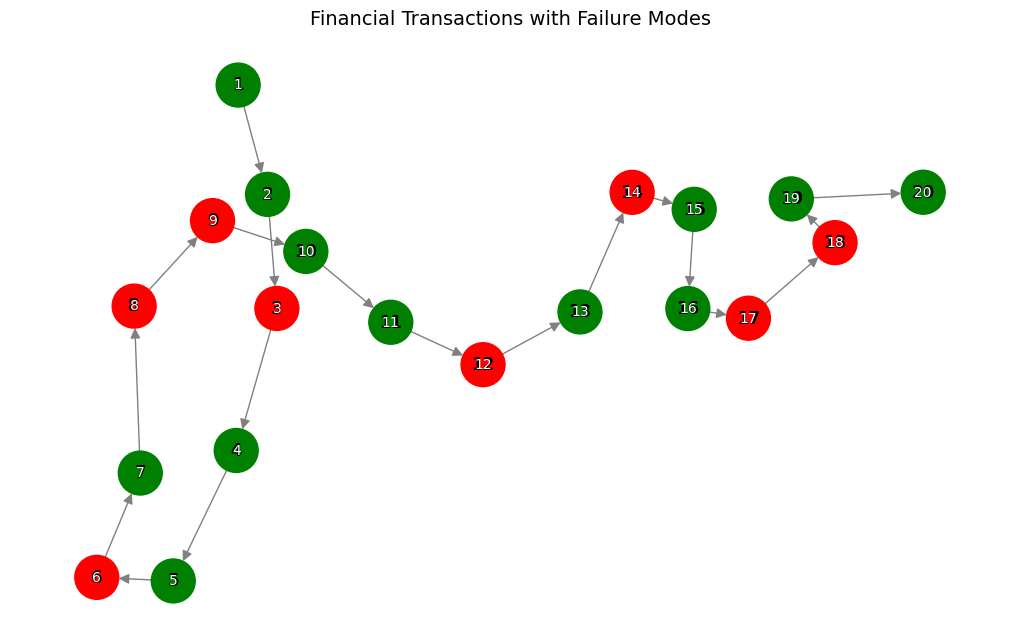

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.DiGraph()

# Add nodes (transactions) with labels
for _, row in df.iterrows():
    color = "red" if row.get("failure_mode", False) else "green"  # Ensure column exists
    G.add_node(row["transaction_id"], color=color, label=f"{row['transaction_id']}")

# Add edges (NEXT_TRANSACTION relationships)
for i in range(len(df) - 1):
    G.add_edge(df.loc[i, "transaction_id"], df.loc[i+1, "transaction_id"])

# Define layout
pos = nx.spring_layout(G, seed=42)  # Spring layout for even spacing

# Get node colors
node_colors = [G.nodes[n]["color"] for n in G.nodes]

# Draw graph with clear spacing
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=1000, font_size=12, font_weight="bold", arrows=True, arrowsize=15)

# Draw node labels for better visibility
labels = {n: G.nodes[n]["label"] for n in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="white")

plt.title("Financial Transactions with Failure Modes", fontsize=14)
plt.show()


In [3]:
!pip install gradio 

In [4]:
import gradio as gr
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase

# Neo4j connection details
URL = "bolt://localhost:7687"  
USERNAME = "neo4j"
PASSWORD = "password"

# Connect to Neo4j
driver = GraphDatabase.driver(URL, auth=(USERNAME, PASSWORD))

# Generate sample transactions with anomalies
np.random.seed(42)
data = {
    "transaction_id": range(1, 21),
    "account_from": ["A1", "A2", "A3", "A1", "A2", "A3", "A1", "A2", "A3", "A1",
                     "A4", "A5", "A1", "A2", "A6", "A1", "A2", "A3", "A7", "A8"],
    "account_to": ["B1", "B2", "B3", "B1", "B2", "B3", "B1", "B2", "B3", "B1",
                   "B4", "B5", "B6", "B7", "B8", "B1", "B2", "B3", "B9", "B10"],
    "amount": [100, 200, 5000, 150, 200, 5000, 100, 0, 6000, 150,
               -50, 7500, 200, 10000, 150, 2500, 0, 9000, 180, -100],
    "type": ["transfer", "transfer", "credit", "transfer", "transfer", "credit",
             "transfer", "transfer", "credit", "transfer",
             "refund", "credit", "transfer", "credit", "transfer",
             "transfer", "transfer", "credit", "refund", "credit"],
    "timestamp": pd.date_range("2024-02-01", periods=20, freq="h")
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Define failure modes
large_amount_threshold = 3000
df["large_amount"] = df["amount"] > large_amount_threshold
df["zero_amount"] = df["amount"] == 0
df["duplicate"] = df.duplicated(subset=["account_from", "account_to", "amount", "timestamp"], keep=False)
df["failure_mode"] = df["large_amount"] | df["zero_amount"] | df["duplicate"]

# Insert transactions into Neo4j
def insert_transaction(tx, transaction):
    query = """
    CREATE (t:Transaction {transaction_id: $transaction_id, account_from: $account_from,
                           account_to: $account_to, amount: $amount, type: $type, timestamp: $timestamp})
    """
    tx.run(query, **transaction)

with driver.session() as session:
    for _, row in df.iterrows():
        session.write_transaction(insert_transaction, row.to_dict())

print("Inserted transactions into Neo4j!")

# Create relationships in Neo4j
def create_relationships(tx):
    query = """
    MATCH (t1:Transaction), (t2:Transaction) 
    WHERE t1.timestamp < t2.timestamp
    CREATE (t1)-[:NEXT_TRANSACTION]->(t2)
    """
    tx.run(query)

with driver.session() as session:
    session.write_transaction(create_relationships)

print("Created transaction relationships in Neo4j!")

# Function to plot the financial transactions graph
def plot_graph():
    G = nx.DiGraph()

    for _, row in df.iterrows():
        color = "red" if row.get("failure_mode", False) else "green"
        G.add_node(row["transaction_id"], color=color, label=f"{row['transaction_id']}")

    for i in range(len(df) - 1):
        G.add_edge(df.loc[i, "transaction_id"], df.loc[i+1, "transaction_id"])

    pos = nx.spring_layout(G, seed=42)
    node_colors = [G.nodes[n]["color"] for n in G.nodes]

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
            node_size=1000, font_size=12, font_weight="bold", arrows=True, arrowsize=15)

    labels = {n: G.nodes[n]["label"] for n in G.nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="white")

    plt.title("Financial Transactions with Failure Modes", fontsize=14)
    plt.savefig("graph.png")  # Save image for Gradio
    return "graph.png"

# Function to return DataFrame for table display
def get_transaction_data():
    return df[["transaction_id", "account_from", "account_to", "amount", "type", "timestamp", "failure_mode"]]

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## 💰 **Financial Transactions Analysis**")
    gr.Markdown("🛑 Red Nodes = Anomalies | ✅ Green Nodes = Normal Transactions")

    with gr.Row():
        btn = gr.Button("Generate Graph")
        img = gr.Image()
    btn.click(plot_graph, outputs=img)

    gr.Markdown("### 📊 **Transaction Data Table**")
    table = gr.Dataframe(get_transaction_data())

# Run Gradio UI
demo.launch()


C:\Users\loksa\AppData\Local\Temp\ipykernel_8808\2849573836.py:53: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insert_transaction, row.to_dict())


Inserted transactions into Neo4j!


C:\Users\loksa\AppData\Local\Temp\ipykernel_8808\2849573836.py:67: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_relationships)


Created transaction relationships in Neo4j!
* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
